In [7]:
import os
import numpy as np
import math
import cv2
import glob
from  matplotlib import pyplot as plt
%matplotlib inline
from keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
print(tf.__version__)
'''
https://www.tensorflow.org/tutorials/load_data/images
從磁碟機讀取 image dataset方法
'''
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPool2D, Dense, Flatten, Dropout
from tensorflow.keras.models import Model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import optimizers

2.1.0


Using TensorFlow backend.


In [8]:
# dataset
validation_dir=r'C:\Users\User\Desktop\paper\Flower Classification and Recognition Based on Significance Test and Transfer Learning\flower_data\valid'  # testing data
train_dir=r'C:\Users\User\Desktop\paper\Flower Classification and Recognition Based on Significance Test and Transfer Learning\flower_data\train'  # training data
test_dir=r'C:\Users\User\Desktop\paper\Flower Classification and Recognition Based on Significance Test and Transfer Learning\flower_data\test'  # test data
batch_size=32
img_size=(224, 224)
freeze_layers_number=0
classes=sorted([o for o in os.listdir(train_dir)])  # 根据文件名分类

import requests
import json
file_location=r'C:\Users\User\Desktop\paper\Flower Classification and Recognition Based on Significance Test and Transfer Learning\flower_data\cat_to_name.json'
f=open(file_location)
class_names=json.loads(f.read())
class_names = {int(k):v for k,v in class_names.items()}

nb_train_samples = len(glob.glob(train_dir + '/*/*.*'))  # number of training data
nb_validation_samples = len(glob.glob(validation_dir + '/*/*.*'))  # number of validing data
nb_test_samples = len(glob.glob(test_dir + '/*.*'))  # number of test data
print(nb_train_samples,nb_validation_samples,nb_test_samples,'total=',nb_train_samples+nb_validation_samples+nb_test_samples)
'''
data set:
    Oxfordflower-102 public data set, which comes from the flower image database created by the Oxford University Visual Geometry Group.

    https://www.robots.ox.ac.uk/~vgg/data/flowers/102/
'''

6552 818 819 total= 8189


'\ndata set:\n    Oxfordflower-102 public data set, which comes from the flower image database created by the Oxford University Visual Geometry Group.\n\n    https://www.robots.ox.ac.uk/~vgg/data/flowers/102/\n'

In [3]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)
    
'''
這邊影像增強不知道要不要加進更多變化
'''
    
test_datagen = ImageDataGenerator(
    rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
    validation_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical')
'''
ref:Keras split train test set when using ImageDataGenerator
https://stackoverflow.com/questions/42443936/keras-split-train-test-set-when-using-imagedatagenerator

ref:Image data preprocessing
https://keras.io/api/preprocessing/image/
'''

Found 6552 images belonging to 102 classes.
Found 818 images belonging to 102 classes.


'\nref:Keras split train test set when using ImageDataGenerator\nhttps://stackoverflow.com/questions/42443936/keras-split-train-test-set-when-using-imagedatagenerator\n\nref:Image data preprocessing\nhttps://keras.io/api/preprocessing/image/\n'

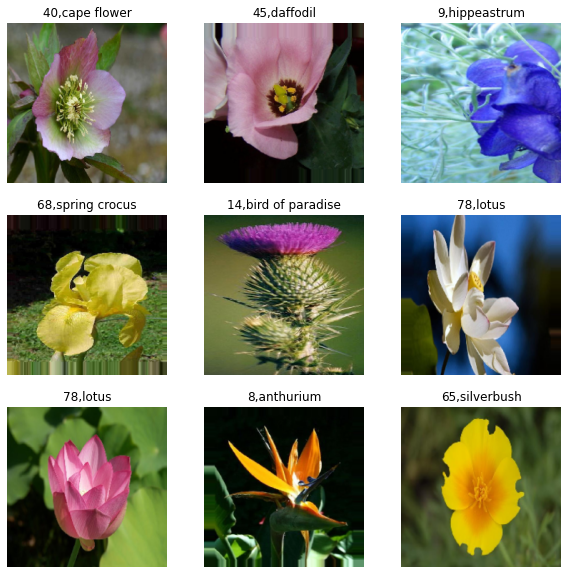

In [4]:
from scipy import ndimage
import scipy.interpolate
datas,labels = train_generator.next()
true_labels=[np.argmax(labels)for labels in labels]
plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(datas[i])
    plt.title(classes[true_labels[i]]+','+class_names[true_labels[i]])
    plt.axis("off")

In [5]:
base_model=VGG16(weights='imagenet',include_top=False,input_tensor=Input(shape=(224,224,3)))

head_model = base_model.output
head_model = Flatten(name="flatten")(head_model)
head_model = Dense(4096,activation="relu",name='fc6')(head_model)
head_model = Dropout(0.5)(head_model)
head_model = Dense(4096,activation='relu',name='fc7')(head_model)
head_model = Dropout(0.5)(head_model)
head_model = Dense(4000,activation='relu',name='fc8')(head_model)
head_model = Dense(102, activation="softmax",name='softmax')(head_model)
model=Model(base_model.input,head_model)

for layer in base_model.layers:
    layer.trainable=True #目前採用 fine tune做法, 不凍結卷積層權重, 跟後面的 fc層一起訓練
model.summary()

'''
這邊參考完 A Survey on Transfer Learning, Dropout: A Simple Way to Prevent Neural Networks from Overfitting
兩篇後做一點修改, paper上繪製的 model需要確定一下
dropout layer (只知道是放在fully connected layer後), transfer方法還需要確定(這邊不知道適用大資料集,不相似資料的 fine tune)
'''

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

'\n這邊參考完 A Survey on Transfer Learning, Dropout: A Simple Way to Prevent Neural Networks from Overfitting\n兩篇後做一點修改, paper上繪製的 model需要確定一下\ndropout layer (只知道是放在fully connected layer後), transfer方法還需要確定(這邊不知道適用大資料集,不相似資料的 fine tune)\n'

In [9]:
dot_img_file = r'C:\Users\user\Downloads\model_1.png'
tf.keras.utils.plot_model(model,to_file=dot_img_file,show_shapes=True,rankdir='LR')

Failed to import pydot. You must install pydot and graphviz for `pydotprint` to work.


In [6]:
num_epoch=100

optimizer=tf.keras.optimizers.SGD(learning_rate=1e-4, momentum=0.9, nesterov=True, name='SGD')

model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
early_stopping = EarlyStopping(verbose=1, patience=5, min_delta=1e-4, monitor='val_accuracy')
callbacks = [early_stopping]

history=model.fit(train_generator,
                  steps_per_epoch=None,
                  validation_data=validation_generator,
                  validation_steps=None,
                  epochs=num_epoch,
                  callbacks=callbacks)

print('Training is finished!')

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 205 steps, validate for 26 steps
Epoch 1/100
205/205 [==============================] - 96s 466ms/step - loss: 4.6305 - accuracy: 0.0261 - val_loss: 4.4701 - val_accuracy: 0.0550
Epoch 2/100
205/205 [==============================] - 86s 419ms/step - loss: 4.5156 - accuracy: 0.0403 - val_loss: 4.3933 - val_accuracy: 0.0611
Epoch 3/100
205/205 [==============================] - 88s 427ms/step - loss: 4.4322 - accuracy: 0.0636 - val_loss: 4.2195 - val_accuracy: 0.1002
Epoch 4/100
205/205 [==============================] - 88s 428ms/step - loss: 4.2481 - accuracy: 0.0914 - val_loss: 3.8767 - val_accuracy: 0.1724
Epoch 5/100
205/205 [==============================] - 86s 418ms/step - loss: 3.9248 - accuracy: 0.1354 - val_loss: 3.2372 - val_accuracy: 0.2861
Epoch 6/100
205/205 [==============================] - 91s 444ms/step - loss: 3.4593 - accuracy: 0.2128 - val_loss: 2.5353 - val_accuracy: 0.4046
Epoch 7/100
205/205 [==========

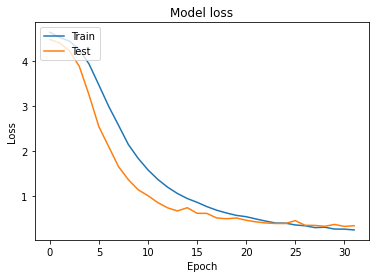

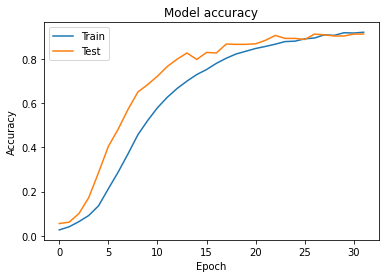

In [7]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss']) 
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [8]:
model.save('fc_vgg16.h5')

In [1]:
'''
model.save('fc_vgg16.h5')
'''
from tensorflow.keras.models import load_model
model = load_model(r'C:\Users\user\fc_vgg16.h5')

In [10]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
file_path=r'C:\Users\User\Desktop\paper\Flower Classification and Recognition Based on Significance Test and Transfer Learning\flower_data\valid'
label_path=r'2'
image_path=r'image_05094.jpg'
orig_image = cv2.imread(file_path+'\\'+label_path+'\\'+image_path)
test_image=(orig_image)
test_image = cv2.normalize(test_image.astype('float'), None, 0.0, 1.0, cv2.NORM_MINMAX)
pred_image=cv2.resize(test_image,(224,224))

In [11]:
pred_image.shape

(224, 224, 3)

2:100.00%
19:0.00%
67:0.00%
69:0.00%
40:0.00%


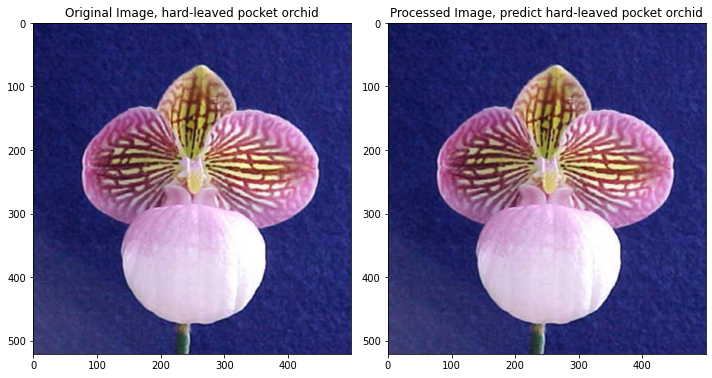

In [12]:
pred_image = pred_image[None]
y = model.predict(pred_image)

for i in np.argsort(y[0])[::-1][:5]:
    print('{}:{:.2f}%'.format(classes[i], y[0][i] * 100))

predict_label=classes[np.argsort(y[0])[::-1][0]]

fig, (ax1, ax2) = plt.subplots(figsize=(10,10), ncols=2)
ax1.imshow(orig_image[:, :, [2, 1, 0]])
ax1.set_title(f'Original Image, {class_names[int(label_path)]}')
ax2.imshow(test_image[:, :, [2, 1, 0]])
ax2.set_title(f'Processed Image, predict {class_names[int(predict_label)]}')
plt.tight_layout()
filename=image_path
plt.savefig(r'C:\Users\User\Downloads'+'\\'+filename)
plt.show()

In [14]:
import time
start=time.time()
num=0
acc=0
for root, dirs, files in os.walk(r'C:\Users\User\Desktop\paper\Flower Classification and Recognition Based on Significance Test and Transfer Learning\flower_data\valid',topdown=False):
    for name in files:
        orig_image = cv2.imread(os.path.join(root,name))
        test_image=(orig_image)
        test_image = cv2.normalize(test_image.astype('float'), None, 0.0, 1.0, cv2.NORM_MINMAX)
        pred_image=cv2.resize(test_image,img_size)
        
        pred_image = pred_image[None]
        y = model.predict(pred_image)
        
        predict_label=classes[np.argsort(y[0])[::-1][0]]

        file=os.path.basename(os.path.dirname(os.path.dirname(root)))
        #print('file')
        subfile_l1=os.path.basename(os.path.dirname(root))
        #print('sub',subfile_l1) #train, test, validation
        subfile_l2=os.path.basename(root)
        #print('sub',subfile_l2) #label
        
        fig, (ax1, ax2) = plt.subplots(figsize=(10,10), ncols=2)
        ax1.imshow(orig_image[:, :, [2, 1, 0]])
        ax1.set_title(f'Original Image, {class_names[int(subfile_l2)]}')
        ax2.imshow(test_image[:, :, [2, 1, 0]])
        #(outputdata*255).astype(np.float64)
        ax2.set_title(f'Processed Image, predict {class_names[int(predict_label)]}')
        plt.tight_layout()
        
        write_path=os.path.abspath(os.path.join(root, "../.."))+'_predict fc_vgg16'
        
        #print(name) #image name
        #print('write_path',write_path)
        
        if subfile_l2==predict_label:
            if os.path.exists(write_path)==False:
                os.mkdir(write_path)
            if os.path.exists(write_path+'\\'+subfile_l1+'_true')==False:
                os.mkdir(write_path+'\\'+subfile_l1+'_true')
            if os.path.exists(write_path+'\\'+subfile_l1+'_true'+'\\'+subfile_l2)==False:
                os.mkdir(write_path+'\\'+subfile_l1+'_true'+'\\'+subfile_l2)

            plt.savefig(write_path+'\\'+subfile_l1+'_true'+'\\'+subfile_l2+'\\'+name)
            acc+=1
        if subfile_l2!=predict_label:
            if os.path.exists(write_path)==False:
                os.mkdir(write_path)
            if os.path.exists(write_path+'\\'+subfile_l1+'_false')==False:
                os.mkdir(write_path+'\\'+subfile_l1+'_false')
            if os.path.exists(write_path+'\\'+subfile_l1+'_false'+'\\'+subfile_l2)==False:
                os.mkdir(write_path+'\\'+subfile_l1+'_false'+'\\'+subfile_l2)
            
            plt.savefig(write_path+'\\'+subfile_l1+'_false'+'\\'+subfile_l2+'\\'+name)
        plt.close()
        num+=1
end=time.time()
print('accuracy=',acc/num)
print(end-start)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


accuracy= 0.578239608801956
203.0190360546112
